In [46]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow.keras.callbacks as callbacks
from tensorflow.keras.utils import plot_model 

from nltk import sent_tokenize
import nltk
from tqdm import tqdm 
import numpy as np
import re
import string
import pandas as pd
from collections import OrderedDict

In [3]:
# !pip install pyarabic
# nltk.download('punkt')

In [6]:
path_to_file = 'data/40000-Egyptian-tweets.xlsx'

In [7]:
df = pd.read_excel(path_to_file)

In [8]:
df.drop(['label'], axis=1, inplace=True)

In [9]:
df.head()

,review
0,اكبر خطا ترتكبه ان تعامل الناس باخلاقك انت مش ...
1,دائما اكره اخر ليله في كل مكان .
2,يارب اللى يسرق تويتاتى يدخل النار .
3,الاسراف فى تناول القهوة يسبب الوفاه .
4,انا اتبهدلت من التراب النهارده. حاجة تقرف .


In [10]:
df.to_numpy()[0]

array(['اكبر خطا ترتكبه ان تعامل الناس باخلاقك انت مش باخلاقهم هما  .  '],
      dtype=object)

In [11]:
corpus = [sent[0] for sent in df.to_numpy()]
corpus[:2]

['اكبر خطا ترتكبه ان تعامل الناس باخلاقك انت مش باخلاقهم هما  .  ',
 'دائما اكره اخر ليله في كل مكان   .  ']

### Preprocessing 

In [12]:
punctuation_string = '!"\\\\#\\$%\\&\\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~\d'

In [13]:
import pyarabic.araby as araby
from pyarabic.araby import strip_tashkeel, strip_tatweel, strip_tashkeel, is_arabicrange

In [14]:
def split_al(word):
    if word.startswith('ال'):
        return word[:2], word[2:]
    else: 
        return word

    
split_al('الراحه')

('ال', 'راحه')

In [15]:
def split_al_sent(sent):
    ww = []
    for word in sent.split():
        out = split_al(word)
        if type(out) is tuple:
            for w in out:
                ww.append(w)
        else:
            ww.append(word)
    return ' '.join(w for w in ww)

In [16]:
split_al_sent('الراحه ببساطة فى القرآن فى الصلاة فى الدعاء فى...')

'ال راحه ببساطة فى ال قرآن فى ال صلاة فى ال دعاء فى...'

In [17]:
conditions = [is_arabicrange]
morphs = [strip_tashkeel, strip_tatweel]

In [18]:
def preprocess(corpus):
    sentences = sent_tokenize(' '.join(w for w in corpus))
#     sentences = [sent.lower() for sent in sentences]
#     sentences = [re.sub('<\w+>', '', sent) for sent in sentences]
    sentences = [sent.decode() for sent in 
                 tf.strings.regex_replace(sentences,f'[{punctuation_string}]', '').numpy()]
    sentences = [split_al_sent(sent) for sent in sentences]
    sentences = [araby.normalize_hamza(sent, method='tasheel') for sent in sentences]
#     tokens = [word_tokenize(sent) for sent in tqdm(sentences)]
    tokens = [araby.tokenize(sent, conditions=conditions, morphs=morphs) for sent in tqdm(sentences)]
    # return tokenized sentences
    return tokens

In [19]:
tokens_list = preprocess(corpus)

100%|██████████| 44996/44996 [00:01<00:00, 42207.62it/s]


In [20]:
len(tokens_list)

44996

In [21]:
print(tokens_list[0])

['اكبر', 'خطا', 'ترتكبه', 'ان', 'تعامل', 'ال', 'ناس', 'باخلاقك', 'انت', 'مش', 'باخلاقهم', 'هما']


In [56]:
def build_vocabulary(tokens_list, top_n=10000):
    freqs = {}

    # get the freqs
    for tokens in tqdm(tokens_list):
        for word in tokens:
            if word not in freqs:
                freqs[word] = 1
            else:
                freqs[word] += 1
    # sort the freqs
    freqs = OrderedDict(sorted(freqs.items(), key=lambda x: x[1], reverse=True))
    
    # get the first top_n words
    top_n_words = list(freqs)[:top_n]
    
    
    stoi = {'<pad>': 0, '<unk>': 1}
    itos = {0: '<pad>', 1: '<unk>'}
    idx = 2
    
    for word in tqdm(top_n_words):
        if word not in stoi:
            stoi[word] = idx
            itos[idx] = word
            idx += 1
    
    
    return stoi, itos

In [57]:
stoi, itos = build_vocabulary(tokens_list)

100%|██████████| 10000/10000 [00:00<00:00, 2398801.26it/s]


In [69]:
def numericalize(tokens_list):
    numericalized = []
    for sent in tokens_list:
        n_set = []
        for w in sent:
            if w in stoi:
                n_set.append(stoi[w])
            else:
                n_set.append(stoi['<unk>'])
        numericalized.append(n_set)
    
    return numericalized

In [32]:
vocab_size = len(stoi)
embed_size = 300
window_size = 2

print(f"Vocab Size  : {vocab_size}")
print(f"Vocab Sample: {list(stoi.items())[:5]}")

Vocab Size  : 49454
Vocab Sample: [('<pad>', 0), ('اكبر', 1), ('خطا', 2), ('ترتكبه', 3), ('ان', 4)]


In [33]:
def generate_context_target_pairs(corpus=numericalized, window_size=2, vocab_size=vocab_size):
    
    context_length = window_size * 2
    
    for sentence in corpus:
        sentence_length = len(sentence)
        
        for index, word in enumerate(sentence):
            context_words = []
            label_word = []
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([sentence[i] for i in range(start, end)
                                 if 0 <= i < sentence_length and i != index])
            label_word.append(word)
            
            x = pad_sequences(context_words, maxlen=context_length)
            y = to_categorical(label_word, vocab_size)
            yield(x[0], y[0])

In [34]:
i = 0
for x, y in generate_context_target_pairs(numericalized, 2, vocab_size):
    if 0 not in x:
        if i == 10: break
        i+=1

        print(f'Target: {itos[np.argmax(y)]}, Context: {[itos[w] for w in x]}')

Target: ترتكبه, Context: ['اكبر', 'خطا', 'ان', 'تعامل']
Target: ان, Context: ['خطا', 'ترتكبه', 'تعامل', 'ال']
Target: تعامل, Context: ['ترتكبه', 'ان', 'ال', 'ناس']
Target: ال, Context: ['ان', 'تعامل', 'ناس', 'باخلاقك']
Target: ناس, Context: ['تعامل', 'ال', 'باخلاقك', 'انت']
Target: باخلاقك, Context: ['ال', 'ناس', 'انت', 'مش']
Target: انت, Context: ['ناس', 'باخلاقك', 'مش', 'باخلاقهم']
Target: مش, Context: ['باخلاقك', 'انت', 'باخلاقهم', 'هما']
Target: اخر, Context: ['دايما', 'اكره', 'ليله', 'في']
Target: ليله, Context: ['اكره', 'اخر', 'في', 'كل']


In [35]:
output_shapes = ([None, window_size*2],[None, vocab_size])
output_shapes

([None, 4], [None, 49454])

In [36]:
output_shapes = ([window_size*2],[vocab_size])
dataset = tf.data.Dataset.from_generator(generate_context_target_pairs, (tf.int32, tf.int32), output_shapes=output_shapes)
dataset = dataset.batch(1000)

In [37]:
for batch, (x, y) in enumerate(dataset):
    break
    #print("batch: ", batch)
print(x.shape, y.shape)

(1000, 4) (1000, 49454)


In [38]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2),
    Lambda(lambda x: keras.backend.mean(x, axis=1), output_shape=(embed_size)),
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 300)            14836200  
_________________________________________________________________
lambda (Lambda)              (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 49454)             14885654  
Total params: 29,721,854
Trainable params: 29,721,854
Non-trainable params: 0
_________________________________________________________________


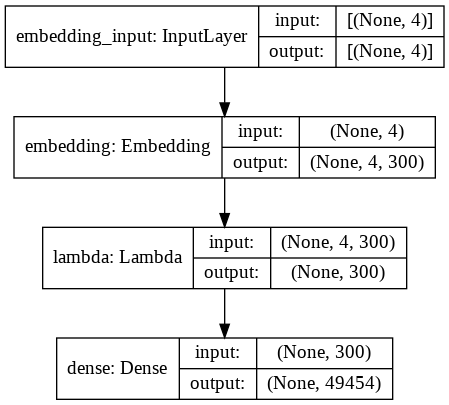

In [40]:
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [41]:
google_drive_path = '/content/drive/MyDrive/weights/cbow/ar_full.h5'
# google_drive_path = 'models/test_ar.h5'

In [42]:
early_stopping_cb = callbacks.EarlyStopping(monitor='loss', patience=4, verbose=True)
checkpoint_cb = callbacks.ModelCheckpoint(google_drive_path, monitor='loss', verbose=True, save_best_only=True)
tensorboard_callback = callbacks.TensorBoard(log_dir="logs")

callbacks_list = [early_stopping_cb, checkpoint_cb, tensorboard_callback]

history = model.fit(dataset, epochs=30, callbacks=callbacks_list)

Epoch 1/30
414/414 [==============================] - 263s 628ms/step - loss: 9.5213 - accuracy: 0.1124

Epoch 00001: loss improved from inf to 8.67453, saving model to /content/drive/MyDrive/weights/cbow/ar_full.h5
Epoch 2/30
414/414 [==============================] - 258s 624ms/step - loss: 7.7157 - accuracy: 0.1261

Epoch 00002: loss improved from 8.67453 to 7.67251, saving model to /content/drive/MyDrive/weights/cbow/ar_full.h5
Epoch 3/30
414/414 [==============================] - 258s 622ms/step - loss: 7.4484 - accuracy: 0.1304

Epoch 00003: loss improved from 7.67251 to 7.41896, saving model to /content/drive/MyDrive/weights/cbow/ar_full.h5
Epoch 4/30
414/414 [==============================] - 257s 620ms/step - loss: 7.1971 - accuracy: 0.1382

Epoch 00004: loss improved from 7.41896 to 7.16205, saving model to /content/drive/MyDrive/weights/cbow/ar_full.h5
Epoch 5/30
414/414 [==============================] - 255s 615ms/step - loss: 6.9172 - accuracy: 0.1510

Epoch 00005: loss i

In [43]:
history = model.fit(dataset, epochs=30, callbacks=callbacks_list)

Epoch 1/30
414/414 [==============================] - 252s 609ms/step - loss: 1.8635 - accuracy: 0.6342

Epoch 00001: loss improved from 1.94895 to 1.86348, saving model to /content/drive/MyDrive/weights/cbow/ar_full.h5
Epoch 2/30
414/414 [==============================] - 253s 611ms/step - loss: 1.7851 - accuracy: 0.6461

Epoch 00002: loss improved from 1.86348 to 1.78514, saving model to /content/drive/MyDrive/weights/cbow/ar_full.h5
Epoch 3/30
414/414 [==============================] - 252s 609ms/step - loss: 1.7133 - accuracy: 0.6573

Epoch 00003: loss improved from 1.78514 to 1.71335, saving model to /content/drive/MyDrive/weights/cbow/ar_full.h5
Epoch 4/30
414/414 [==============================] - 252s 608ms/step - loss: 1.6476 - accuracy: 0.6677

Epoch 00004: loss improved from 1.71335 to 1.64759, saving model to /content/drive/MyDrive/weights/cbow/ar_full.h5
Epoch 5/30
414/414 [==============================] - 252s 608ms/step - loss: 1.5873 - accuracy: 0.6772

Epoch 00005: lo